In [18]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve



In [19]:
# Download latest version
path = kagglehub.dataset_download("uciml/human-activity-recognition-with-smartphones")

df_train = pd.read_csv(f"{path}/train.csv")
df_test = pd.read_csv(f"{path}/test.csv")

print(df_train)
print(df_train.describe())
print(df_test.describe())

# target classes
print(df_train["Activity"].unique())


      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.288585          -0.020294          -0.132905   
1              0.278419          -0.016411          -0.123520   
2              0.279653          -0.019467          -0.113462   
3              0.279174          -0.026201          -0.123283   
4              0.276629          -0.016570          -0.115362   
...                 ...                ...                ...   
7347           0.299665          -0.057193          -0.181233   
7348           0.273853          -0.007749          -0.147468   
7349           0.273387          -0.017011          -0.045022   
7350           0.289654          -0.018843          -0.158281   
7351           0.351503          -0.012423          -0.203867   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.995279         -0.983111         -0.913526         -0.995112   
1            -0.998245         -0.975300         -0.960322 

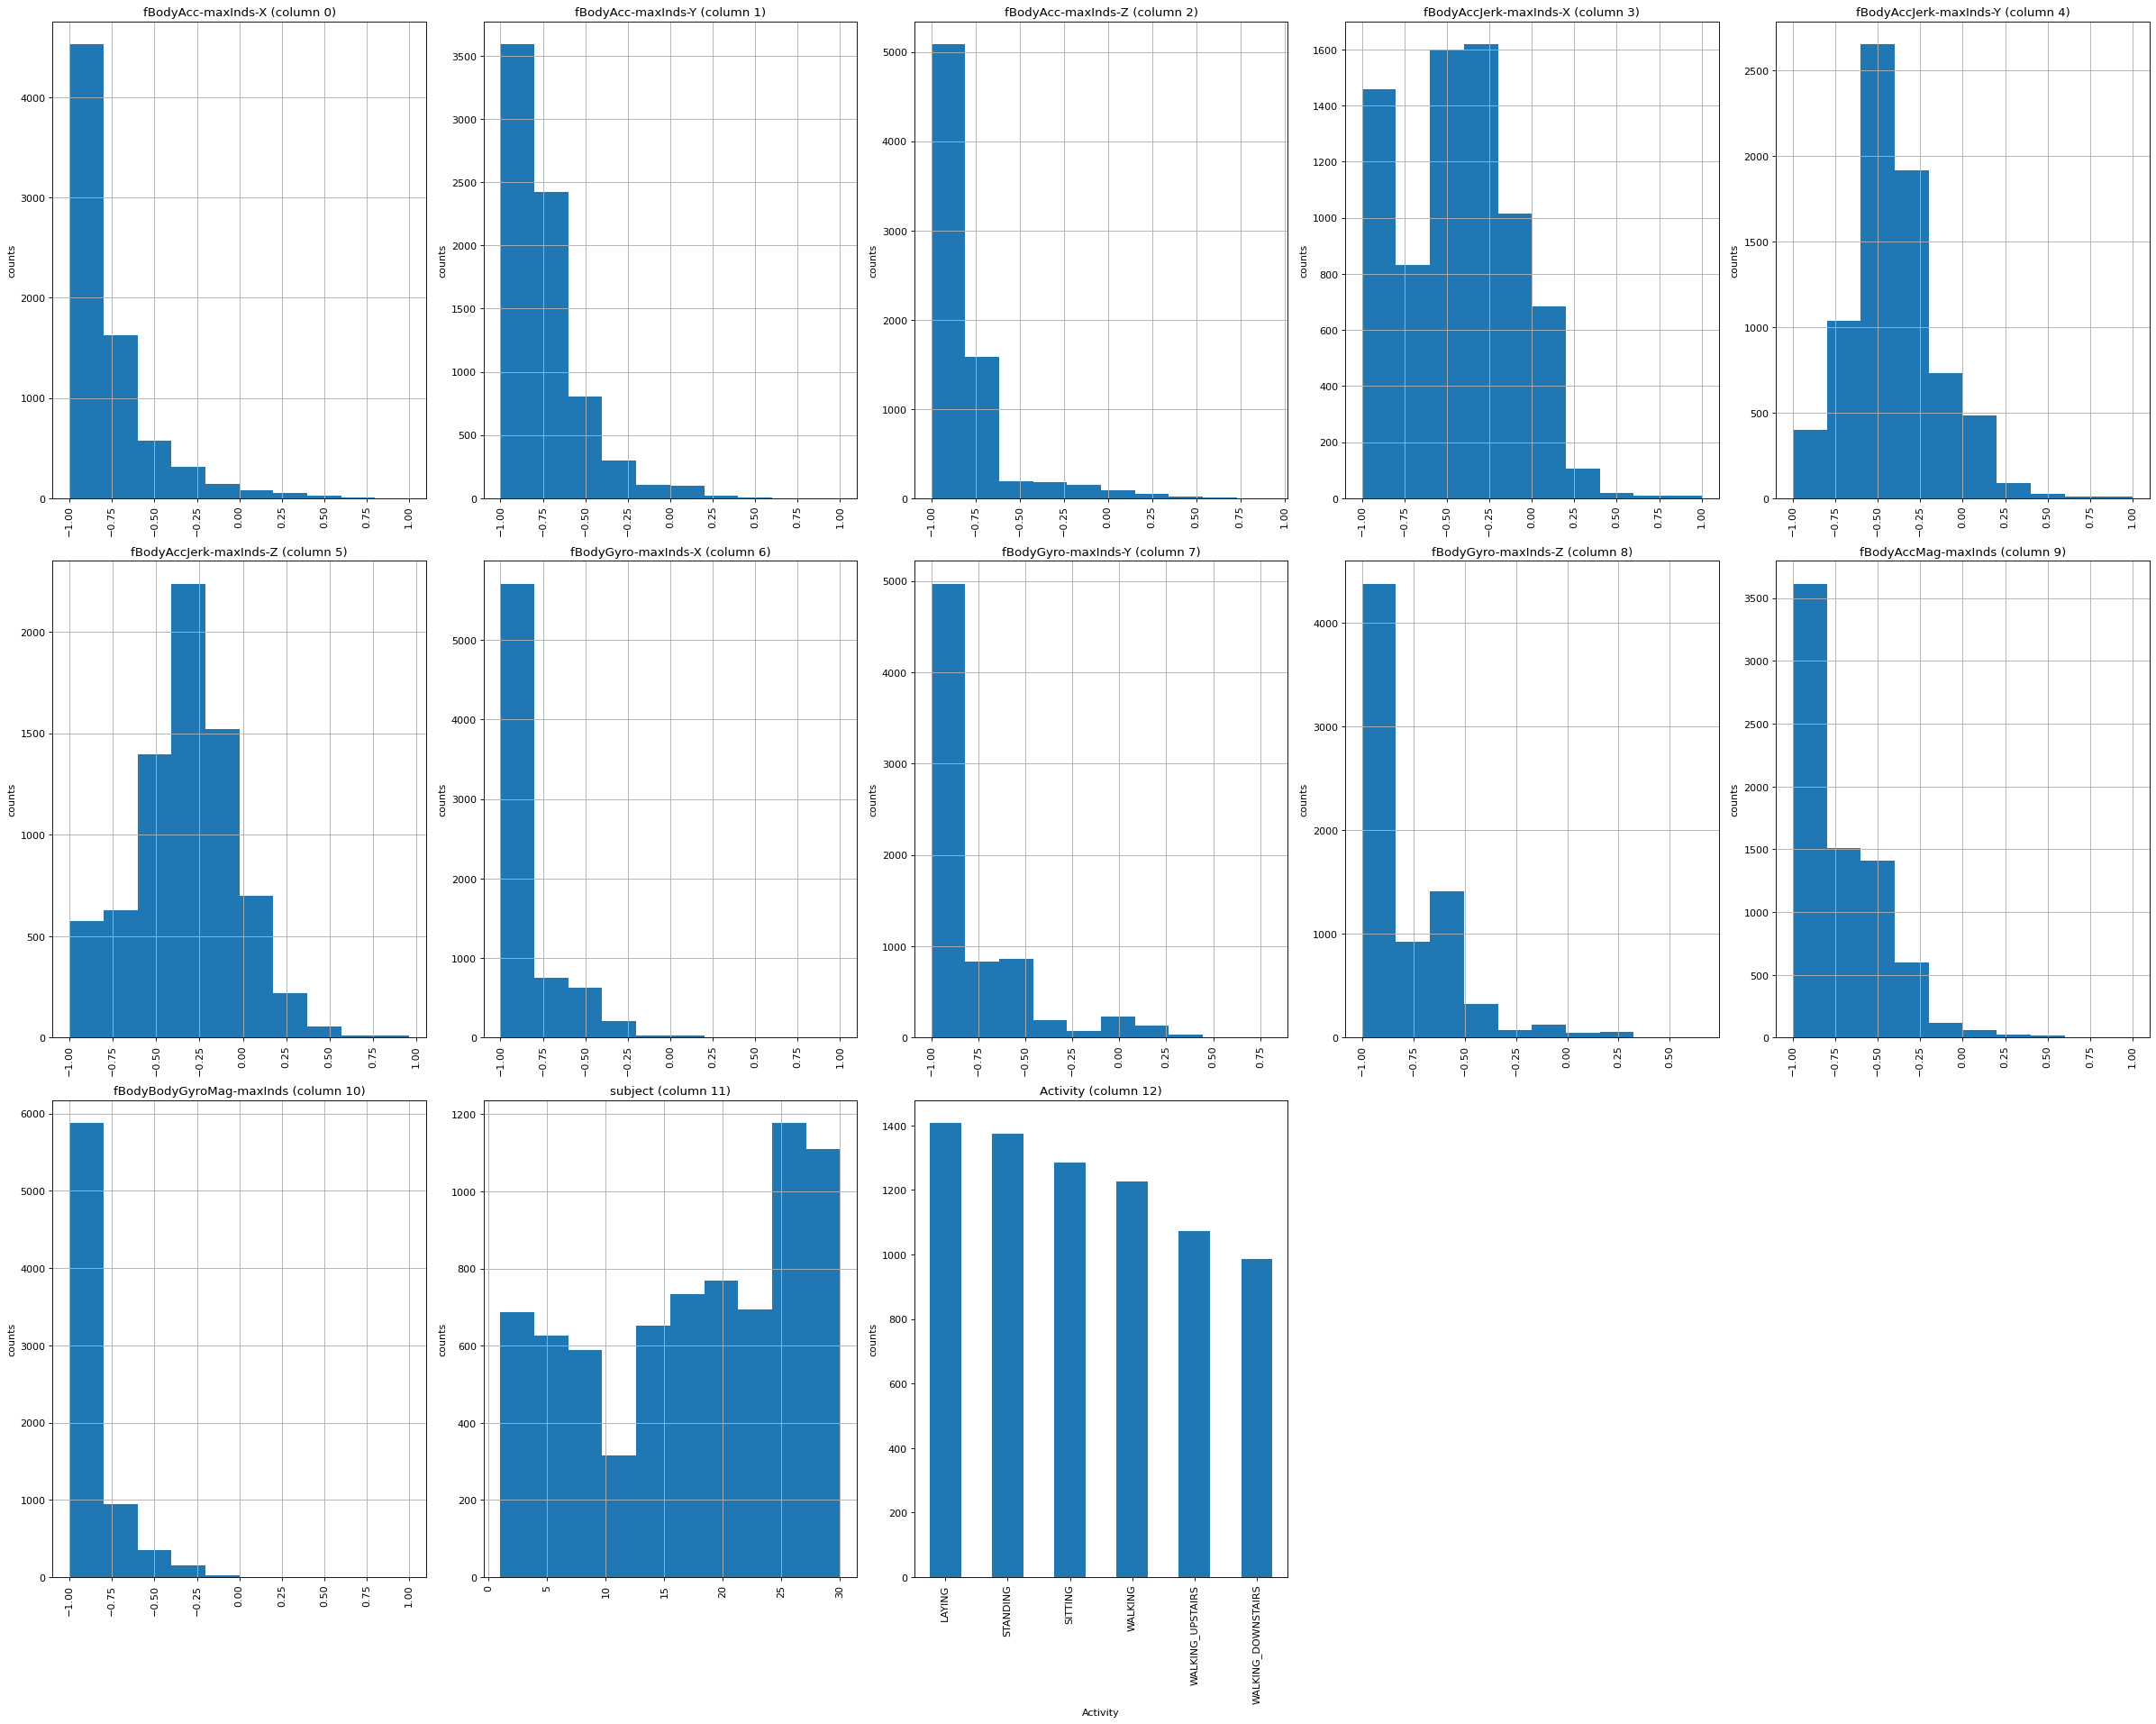

In [20]:
# visualize the data
visualize = True

# helper function to display data distribution (generated by Kaggle bot)
def plot(df, nGraphShown, nGraphPerRow):

    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # for displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()

        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

if visualize:

    plot(df_train, 25, 5)

In [21]:
# data preparation

x_train = df_train.drop('Activity', axis=1)
y_train = df_train['Activity']
x_test = df_test.drop('Activity', axis=1)
y_test = df_test['Activity']

In [22]:
#feature correlation to identify and remove highly correlated features

corr_matrix = x_train.corr()
columns = corr_matrix.columns

dropped = []

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
       if corr_matrix.loc[columns[i], columns[j]] > 0.95:
            dropped.append(columns[j])

dropped = set(dropped)
print(f"number of columns to drop: {len(dropped)}")

x_train.drop(columns = dropped, inplace = True, axis = 1)
x_test.drop(columns = dropped, inplace = True, axis = 1)

print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")


number of columns to drop: 292
x_train.shape: (7352, 270)
x_test.shape: (2947, 270)


In [23]:
# data preprocessing

# convert the targets from strings into integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes = num_classes)
y_test_one_hot = to_categorical(y_test, num_classes = num_classes)

# reshape the data to 3D: number of samples, timestamps and features per timestamp

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [24]:
# build the model


def build_model(x_train):
    model = Sequential([
    Input(shape = (x_train.shape[1], 1)),
    Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size = 2),
    Dropout(0.2),
    LSTM(64, return_sequences = True),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(num_classes, activation = 'softmax')
])

    return model

model = build_model(x_train)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 268, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 268, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 134, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8576)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,097,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,166 (4.32 MB)

 Trainable params: 1,132,038 (4.32 MB)

 Non-trainable params: 128 (512.00 B)

In [25]:
history = model.fit(x_train, y_train_one_hot, validation_split = 0.2, epochs =30, batch_size=64)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5258 - loss: 1.0943 - val_accuracy: 0.1584 - val_loss: 1.7444
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8901 - loss: 0.2723 - val_accuracy: 0.2821 - val_loss: 1.4640
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9527 - loss: 0.1315 - val_accuracy: 0.8246 - val_loss: 0.7699
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9610 - loss: 0.1027 - val_accuracy: 0.9007 - val_loss: 0.4091
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9641 - loss: 0.0967 - val_accuracy: 0.9259 - val_loss: 0.2016
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9728 - loss: 0.0716 - val_accuracy: 0.9347 - val_loss: 0.1646
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9770 - loss: 0.0631 - val_accuracy: 0.9361 - val_loss: 0.1636
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9795 - loss: 0.0551 - val_accuracy: 0.9443 - v

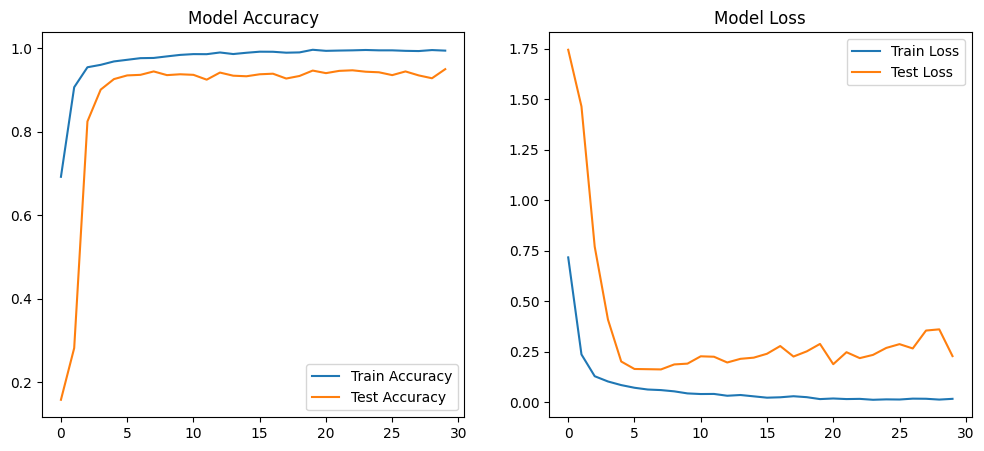

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.94


In [26]:
# plot results

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title(f'Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(f'Model Loss')
plt.legend()
plt.show()

# check the model

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



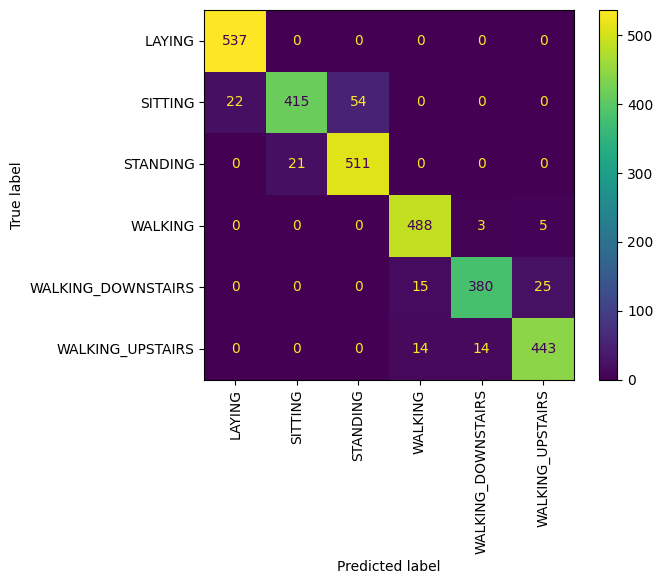

In [28]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels = label_encoder.classes_)
display.plot(xticks_rotation = 'vertical')
plt.show()